In [25]:
# https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/

# Sentiment Analysis with BERT and Transformers by Hugging Face using PyTorch and Python

#!pip install numpy
#!pip install pandas
#!pip install seaborn
#!pip install -qq transformers
# !pip install scikit-learn
# !pip install matplotlib
##python -m pip install --upgrade pip #upgrade pip if not the latest
#!pip install torch
#!pip install transformers

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader



C:\Users\Latitude\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_masked\__init__.py:223: UserWarning: Failed to initialize NumPy: module compiled against API version 0xf but this version of numpy is 0xe (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  example_input = torch.tensor([[-3, -2, -1], [0, 1, 2]])


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# Data Preprocessing


PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

text1 = ''' I recently discovered I could make fudge with just chocolate chips,
sweetened condensed milk, vanilla extract, and a thick pot on slow heat.
I tried it with dark chocolate chunks and I tried it with semi-sweet chocolate chips.
It's better with both kinds. It comes out pretty bad with just the dark chocolate.
The best add-ins are crushed almonds and marshmallows -- what you get from that is Rocky Road.
It takes about twenty minutes from start to fridge, and then it takes about six months to work 
off the twenty pounds you gain from eating it. All things in moderation, friends. All things in moderation.'''

tokens = tokenizer.tokenize(text1)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Original Sentence: {sample_txt}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Original Sentence: When was I last outside? I am stuck at home for 2 weeks.
Tokens: ['I', 'recently', 'discovered', 'I', 'could', 'make', 'f', '##udge', 'with', 'just', 'chocolate', 'chips', ',', 'sweet', '##ened', 'con', '##den', '##sed', 'milk', ',', 'van', '##illa', 'extract', ',', 'and', 'a', 'thick', 'pot', 'on', 'slow', 'heat', '.', 'I', 'tried', 'it', 'with', 'dark', 'chocolate', 'chunk', '##s', 'and', 'I', 'tried', 'it', 'with', 'semi', '-', 'sweet', 'chocolate', 'chips', '.', 'It', "'", 's', 'better', 'with', 'both', 'kinds', '.', 'It', 'comes', 'out', 'pretty', 'bad', 'with', 'just', 'the', 'dark', 'chocolate', '.', 'The', 'best', 'add', '-', 'ins', 'are', 'crushed', 'al', '##mond', '##s', 'and', 'marsh', '##mal', '##lows', '-', '-', 'what', 'you', 'get', 'from', 'that', 'is', 'Rocky', 'Road', '.', 'It', 'takes', 'about', 'twenty', 'minutes', 'from', 'start', 'to', 'fridge', ',', 'and', 'then', 'it', 'takes', 'about', 'six', 'months', 'to', 'work', 'off', 'the', 'twenty', 'po

In [12]:
encoding = tokenizer.encode_plus(
  text1,
  max_length=len(tokens)+32, #max length was originally set 32
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()


dict_keys(['input_ids', 'attention_mask'])

In [14]:
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0])

print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'])

tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])



170


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])

In [16]:
df = pd.read_csv("reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


C:\Users\Latitude\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


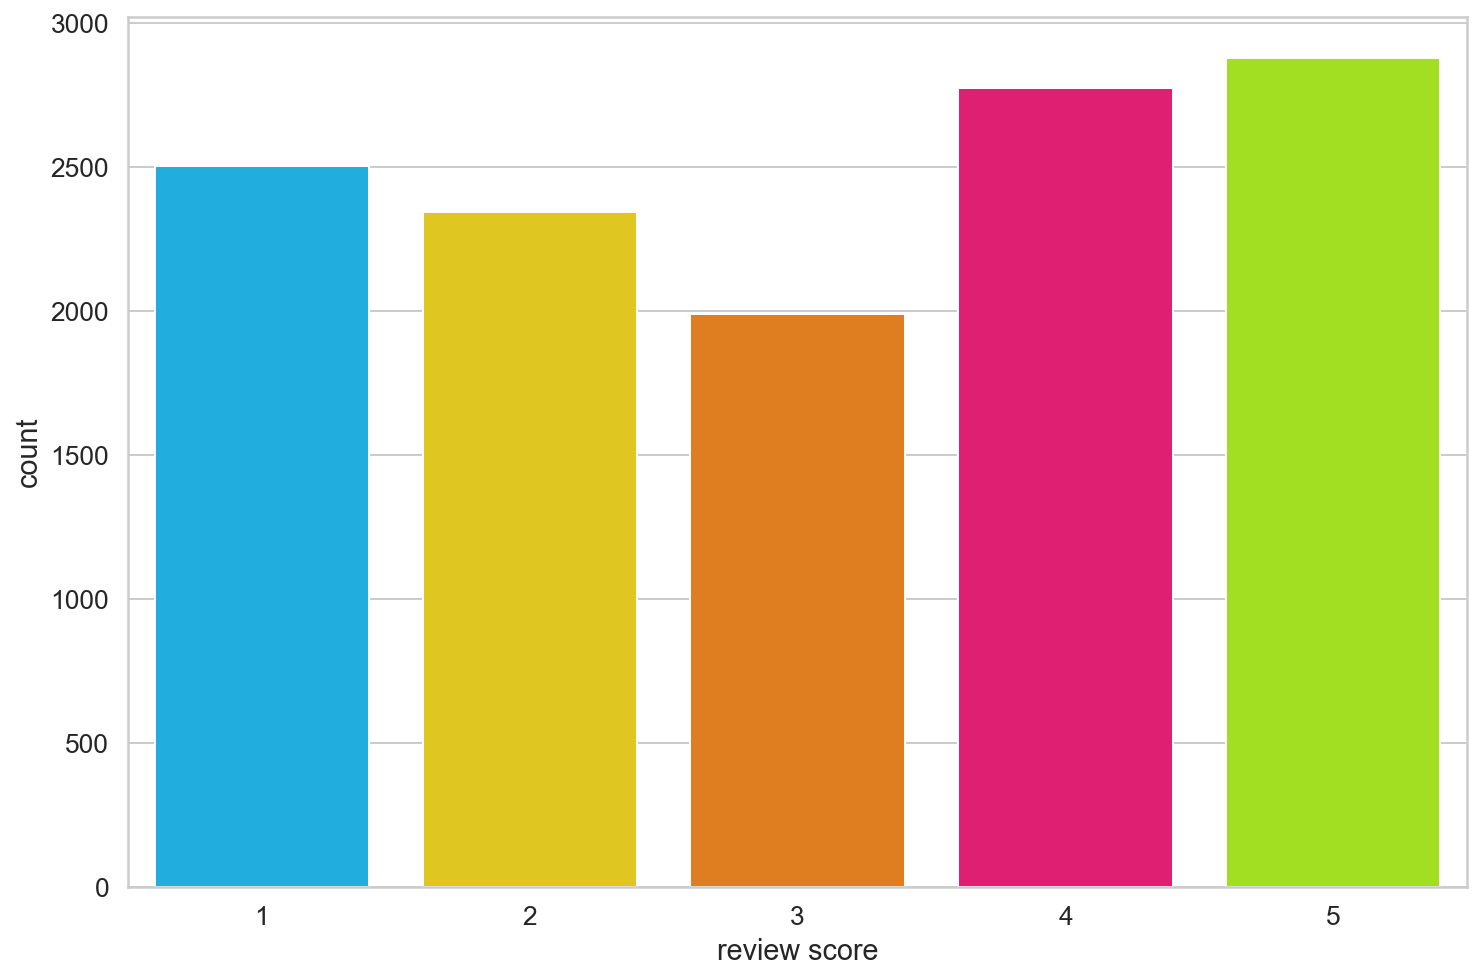

In [17]:
sns.countplot(df.score)
plt.xlabel('review score');

C:\Users\Latitude\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


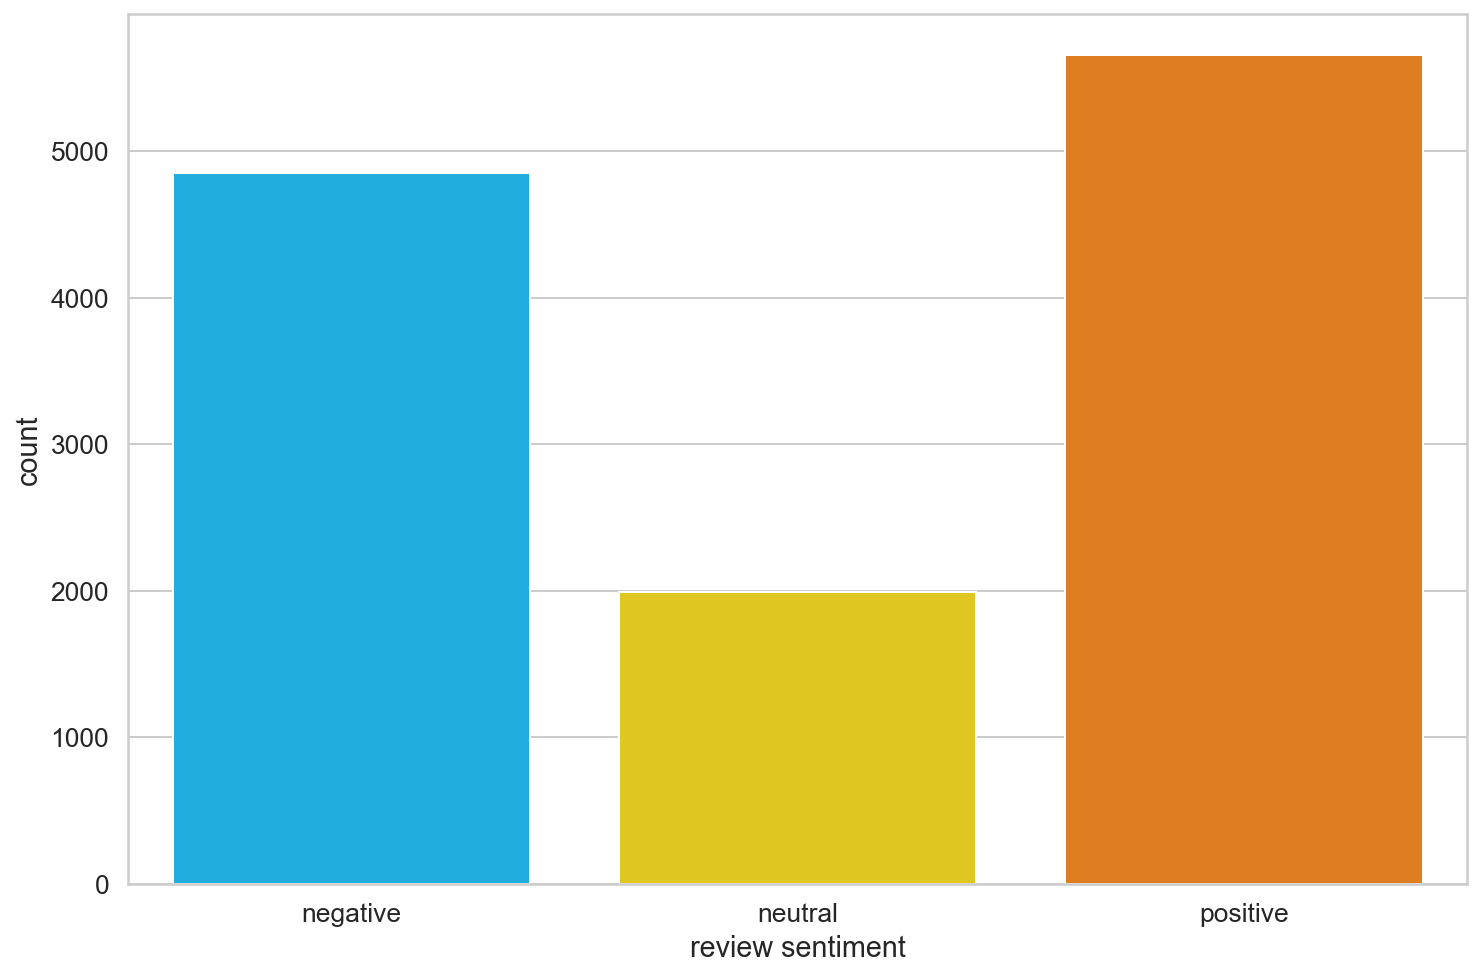

In [18]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['sentiment'] = df.score.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

C:\Users\Latitude\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


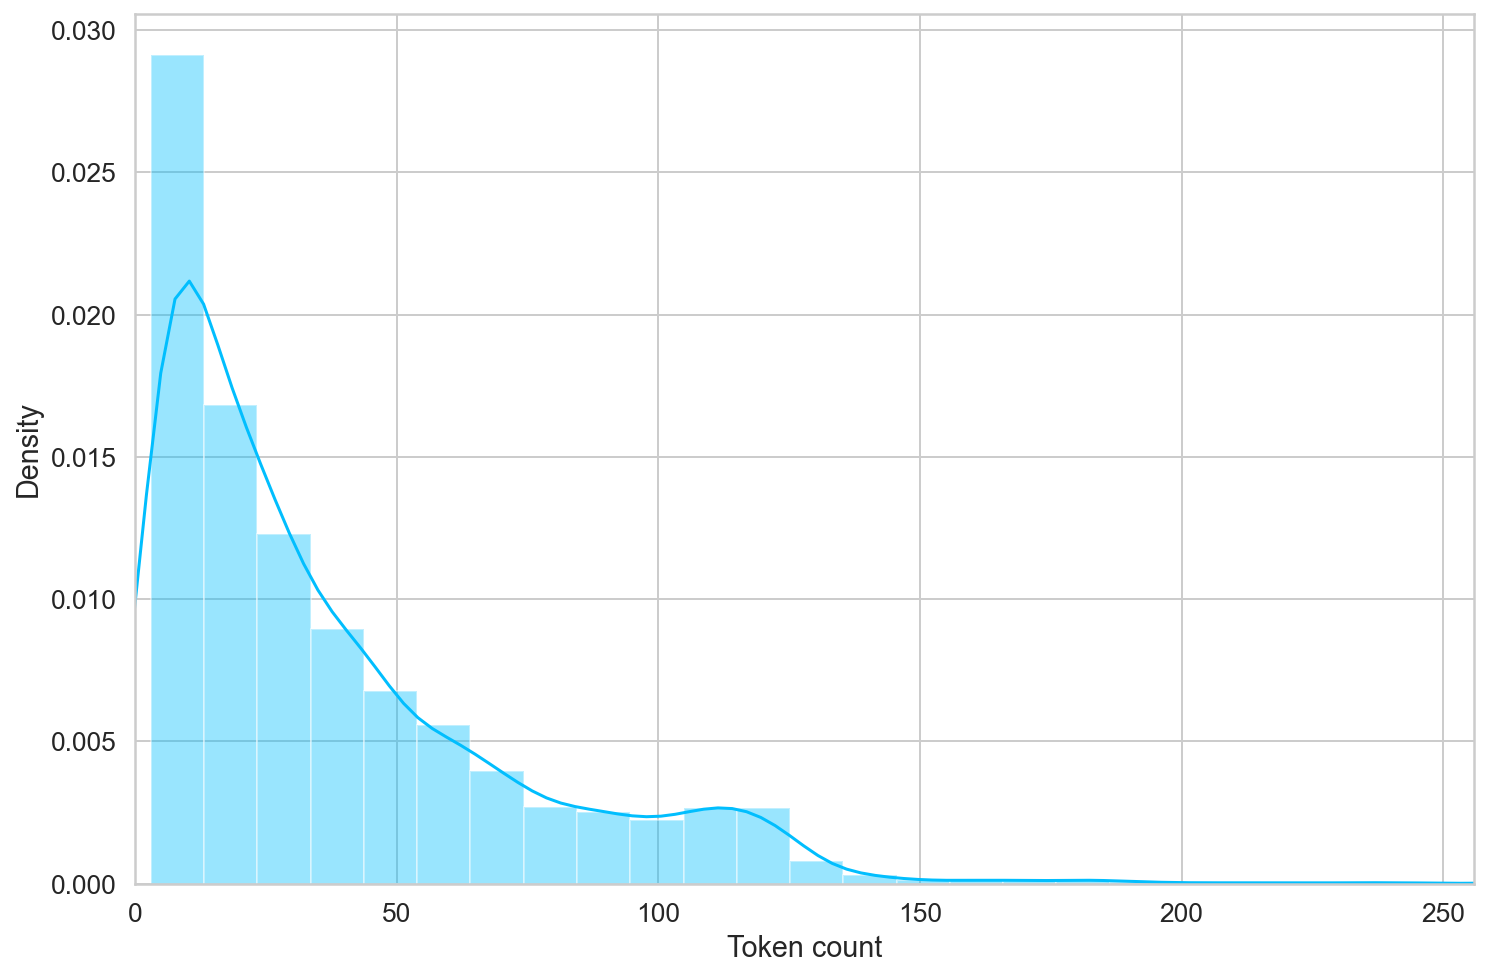

In [20]:
token_lens = []

for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [23]:
# Most of the reviews seem to contain less than 128 tokens, but we’ll be on the safe side and choose a maximum length of 160.
MAX_LEN = 160
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [25]:
#The tokenizer is doing most of the heavy lifting for us. 
# We also return the review texts, so it’ll be easier to evaluate 
# the predictions from our model. Let’s split the data:
df_train, df_test = train_test_split(df,test_size=0.1,random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test,test_size=0.5,random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((11245, 13), (625, 13), (625, 13))

In [26]:
# We also need to create a couple of data loaders.
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(reviews=df.content.to_numpy(),targets=df.sentiment.to_numpy(), tokenizer=tokenizer, max_len=max_len)
    return DataLoader(ds,batch_size=batch_size,num_workers=4)

BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [27]:
data = next(iter(train_data_loader))
data.keys()
dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)


In [1]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
last_hidden_state, pooled_output = bert_model(input_ids=encoding['input_ids'],attention_mask=encoding['attention_mask'])

# The last_hidden_state is a sequence of hidden states of the last layer of the model. Obtaining the pooled_output is done by applying the BertPooler on last_hidden_state:
last_hidden_state.shape
bert_model.config.hidden_size
pooled_output.shape

NameError: name 'BertModel' is not defined

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

F.softmax(model(input_ids, attention_mask), dim=1)

In [ ]:
# Training
# To reproduce the training procedure from the BERT paper,
# we’ll use the AdamW optimizer provided by Hugging Face. 
# It corrects weight decay, so it’s similar to the original paper.
#  We’ll also use a linear scheduler with no warmup steps:

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

oss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
      model = model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in data_loader:
          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)
          targets = d["targets"].to(device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          loss = loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
# Using those two, we can write our training loop. We’ll also store the training history:
%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# So how good is our model on predicting sentiment? Let’s start by calculating the accuracy on the test data:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()


In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

        review_texts.extend(texts)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values



In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"
encoded_review = tokenizer.encode_plus(review_text,max_length=MAX_LEN,add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True, return_tensors='pt',)


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')